<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Miscellaneous/Index_Pairwise_Correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index Pairwise Correlations
---
### Initialize the Workspace
This is done by bringing in a standard library package, which you can find here [my_library.py](https://github.com/Farmhouse121/Financial-Data-Science-in-Python/blob/main/my_library.py). This needs to be imported into the workspace of the project, and then executed. For brevity, we also turn off `UserWarning` and `FutureWarning`. You can skip that step if you want to.

In [1]:
from my_library import *

15:35:53 Starting...
15:35:53 Installing yfinance into Google notebook...
15:36:05 Installing arch into Google notebook...
15:36:14 Initialized.


In [2]:
# let's ignore some warnings that clutter the output, skip this cell if you want to see them
from warnings import filterwarnings

for warning in UserWarning,FutureWarning:
    filterwarnings("ignore",category=warning)

### Store Results in a DataFrame for Meta-Analysis

In [3]:
try:
    #raise Break # uncomment to reset meta dataframe
    display(meta:=pd.read_pickle("/content/drive/MyDrive/meta.pickle"))
    nprint("Read prior meta-analysis results from Google Drive.")

except:
    meta=pd.DataFrame({("Name","Filter"):[],"N":[],"N*":[],"rho":[]}).set_index(("Name","Filter"))
    nprint("Created empty DataFrame for meta-analysis results.")

,,N,N*,rho,Khat
Name,Filter,,,,
S&P 500,,503.0,6.703451,0.147482,75.035975


15:36:14 Read prior meta-analysis results from Google Drive.


### Load List of Index Members
---
This has been set up to allow you to select one of the known indices by setting that value for `indexname`. In the future, more indices might be added via similar code branches.

In [4]:
nprint("Getting members of %s index." % (indexname:='S&P 500'))

index,first_date=loadindex(indexname)
nprint("Total of %d stocks. First date for data extract is %s." % (index.shape[0],first_date))

15:36:14 Getting members of S&P 500 index.


,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
Ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969


15:36:15 Total of 503 stocks. First date for data extract is 2024-09-30.


### Measure Correlations for a Random Sample of Index Member Pairs
---
This analysis is survivorship bias free because data is taken strictly from the last index rebalance only. Fix the random seed to ensure reproducibility.

In [5]:
if (s:=12345678) is not None:
    generator=np.random.default_rng(seed=s)
    nprint("Using NumPy random seed %d." % s)

results=pd.DataFrame({"Trial":list(range(N:=5000)),"Ticker 1":[""]*N,"Ticker 2":[""]*N,"Correlation":[np.nan]*N,"Sample":[np.nan]*N}).set_index("Trial")

nprint("Getting daily data for all index stocks, starting on {:s}.".format(first_date))
data=download(list(map(lambda x:x.replace(".","-") if indexname!='FTSE 250' else x,index.index)),first_date).iloc[:-2] # Yahoo! Finance uses - for subclasses of equity

for i in tqdm(results.index):
    df=data["Adj Close"].sample(2,axis=1,random_state=generator)
    df.columns=pd.MultiIndex.from_product([["Adj Close"],df.columns])

    for ticker in (tickers:=list(set(df.columns.get_level_values(1)))):
        df[('Return',ticker)]=df[('Adj Close',ticker)].pct_change()*hundred

    df.dropna(inplace=True)

    if df.shape[0]<10:
        continue

    df.index=pd.DatetimeIndex(df.index).to_period('D')
    results.loc[i,"Ticker 1"]=tickers[0]
    results.loc[i,"Ticker 2"]=tickers[1]
    results.loc[i,"Correlation"]=df["Return"].corr().iloc[0,1]*hundred
    results.loc[i,"Sample"]=df.shape[0]
    results.loc[i,"Fisher"]=np.arctanh(results.loc[i,"Correlation"]/hundred) # Fisher Transform Correlation
    results.loc[i,"Fisher Error"]=np.sqrt(one/(df.shape[0]-three)) # Approx error
    results.loc[i,"Fisher Z Score"]=results.loc[i,"Fisher"]/results.loc[i,"Fisher Error"]

if results.shape[0]<10:
    raise RuntimeError("Insufficient data (%d) for analysis to proceed." % results.shape[0])

results.set_index(["Ticker 1","Ticker 2"],inplace=True)
results.loc["Mean","Sample"]=results.shape[0]
results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
results.loc["Mean","Fisher"]=(f:=results["Fisher"].mean())
results.loc["Mean","Fisher Z Score"]=(f:=results["Fisher Z Score"].mean())
display(results)

15:36:15 Using NumPy random seed 12345678.
15:36:15 Getting daily data for all index stocks, starting on 2024-09-30.


[*********************100%***********************]  503 of 503 completed


  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-5-6731cedae9d1>:35: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Sample"]=results.shape[0]
<ipython-input-5-6731cedae9d1>:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Correlation"]=(m:=results["Correlation"].mean())
<ipython-input-5-6731cedae9d1>:37: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Fisher"]=(f:=results["Fisher"].mean())
<ipython-input-5-6731cedae9d1>:38: PerformanceWarning: indexing past lexsort depth may impact performance.
  results.loc["Mean","Fisher Z Score"]=(f:=results["Fisher Z Score"].mean())


,,Correlation,Sample,Fisher,Fisher Error,Fisher Z Score
Ticker 1,Ticker 2,,,,,
WBA,ZTS,16.464640,17.0,0.166159,0.267261,0.621709
DOV,TEL,47.408291,17.0,0.515324,0.267261,1.928165
ESS,CLX,39.946076,17.0,0.423007,0.267261,1.582748
IVZ,O,23.559128,17.0,0.240101,0.267261,0.898376
SBAC,BF-B,10.982569,17.0,0.110270,0.267261,0.412594
...,...,...,...,...,...,...
UAL,BLDR,19.483546,17.0,0.197359,0.267261,0.738448
CTVA,TROW,22.674555,17.0,0.230756,0.267261,0.863410
EXR,CFG,18.390906,17.0,0.186026,0.267261,0.696044


### Make Some Histograms...

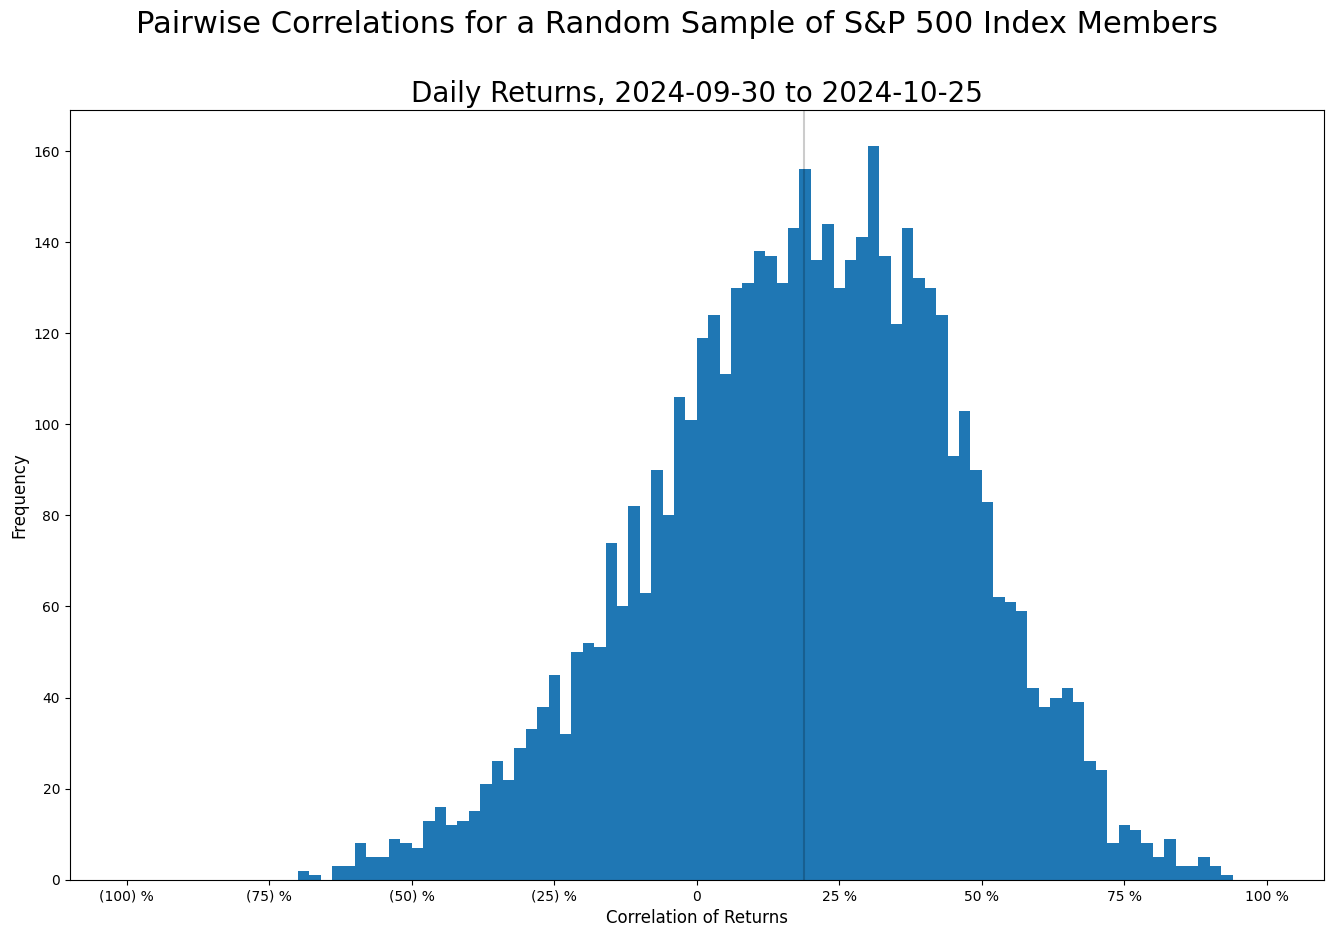

In [6]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
counts,bins,patches=plot.hist(results.loc[results.index!="Mean",'Correlation'].to_numpy(),bins=np.linspace(-hundred,hundred,101))
figure.suptitle(title:="Pairwise Correlations for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("Correlation of Returns",fontsize=12)
plot.xaxis.set_major_formatter(PercentLabels(0))
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(m,color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

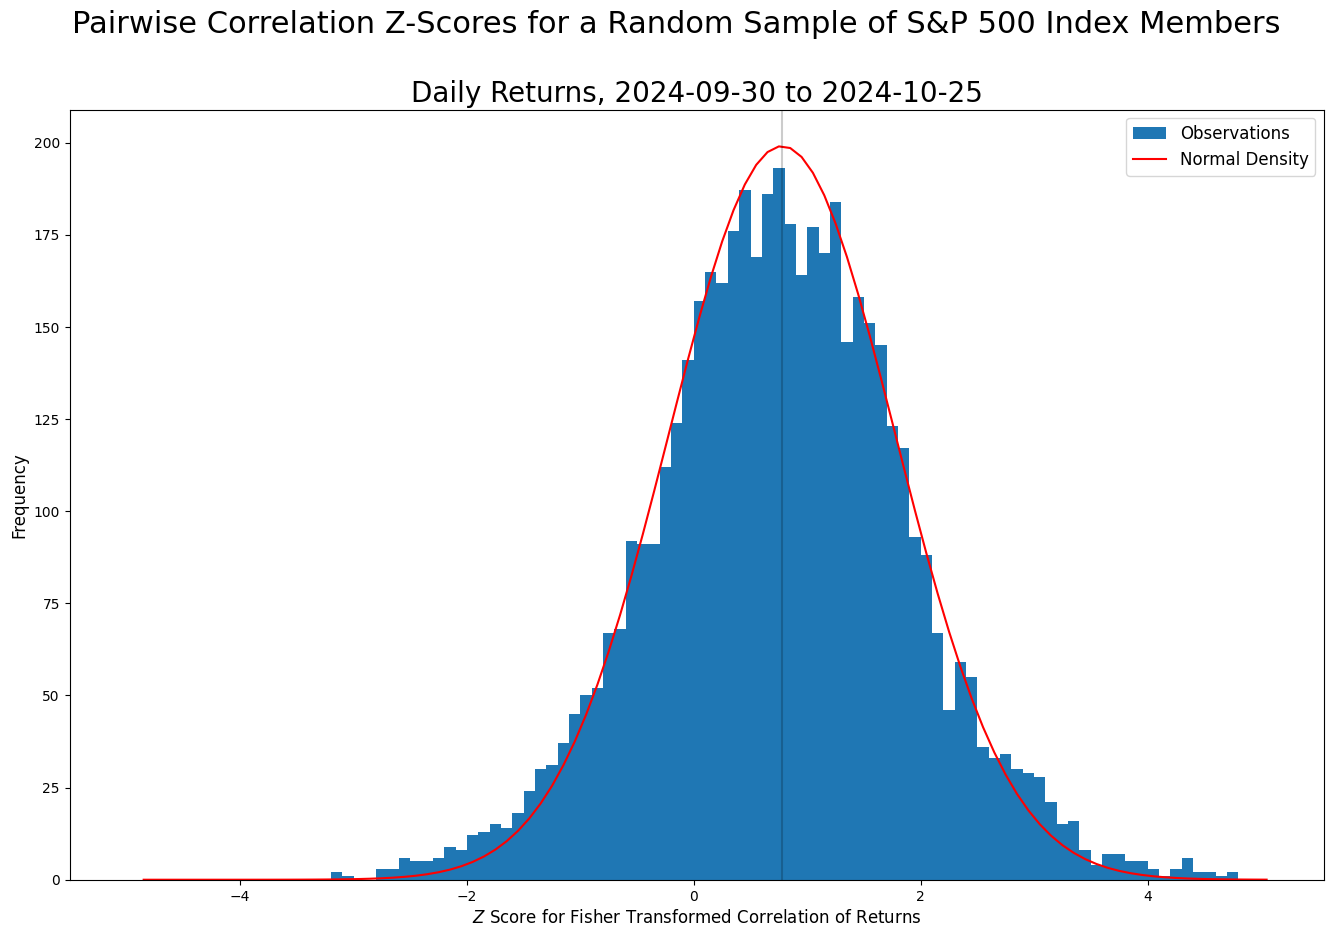

In [7]:
from scipy.stats import norm

Z=results.loc[results.index!="Mean",'Fisher Z Score']
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
counts,bins,patches=plot.hist(Z.to_numpy(),bins=np.linspace(-five,five,101),label='Observations')
plot.plot(x:=bins[1:]+(dx:=bins[1]-bins[0])/two,y:=norm(f,one).pdf(x)*sum(counts)*dx,'-',color='red',label='Normal Density')
figure.suptitle(title:="Pairwise Correlation Z-Scores for a Random Sample of %s Index Members" % indexname,fontsize=22)
plot.set_title(subtitle:="Daily Returns, %s to %s" % (first_date,today("%Y-%m-%d")),fontsize=20)
plot.set_xlabel("$Z$ Score for Fisher Transformed Correlation of Returns",fontsize=12)
plot.set_ylabel("Frequency",fontsize=12)
plot.yaxis.set_major_formatter(CountLabels())
plot.axvline(f,color='black',alpha=0.2)
plot.legend(fontsize=12)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

In [8]:
from scipy.stats import ks_1samp
ks_1samp(Z,norm(f,one).cdf)

KstestResult(statistic=0.023265824021122927, pvalue=0.00876626241530314, statistic_location=-0.3878351291072096, statistic_sign=1)

### Execute the $N^*$ vs. $N$ Analysis
---
$N^*$ is the effective degrees of freedom found within a portfolio of size $N$. This is computed by comparing the variance of the portfolio returns to the variance we would expect if all the stocks were independent.

In [9]:
results=pd.DataFrame({"Sample":range(1,(n:=1000)+1),"Assets":[np.nan]*n,"Portfolio":[np.nan]*n,"Stocks":[""]*n}).set_index("Sample") # n is number of trials
nprint("Getting daily data for all index stocks, starting on %s." % first_date)
closes=data['Adj Close']
closes.index=pd.DatetimeIndex(closes.index).to_period('B')

nprint("Beginning analysis for {:,d} trials.".format(n))

if (filter:=None) is not None: # choose "Up", "Down" or None
    nprint("Limiting analysis to portfolio %s days only." % filter.lower())
    #returns=closes.pct_change().iloc[1:]*hundred
    #select=returns.mean(axis=1)>zero if filter=='Up' else returns.mean(axis=1)<zero if filter=='Down' else ~returns.mean(axis=1).isna()

for i in tqdm(results.index): # for each trial, pick a random sample of stocks with portfolio sizes uniformly distributed between 1 and maximum, one of 2^503-1 choices
    returns=pd.DataFrame()

    for ticker in closes[generator.choice(closes.columns,generator.integers(1,closes.shape[1]+1),replace=False)]:
        returns[ticker]=closes[ticker].pct_change().dropna()*hundred # compute all adjusted returns, ticker by ticker

        if returns[ticker].shape[0]<1: # exclude time-series that are all NA's
            returns.drop(columns=ticker,inplace=True)

        else:
            returns=returns.copy() # 'cos it frags, apparently

    results.loc[i,"Stocks"]=",".join(returns.columns) # list of stocks in portfolio
    returns.drop(returns.index[-1],inplace=True) # get rid of final print in case unprocessed corporate actions exist
    returns['Portfolio']=returns.mean(axis=1) # equal weighted portfolio return
    select=returns["Portfolio"]>zero if filter=="Up" else returns["Portfolio"]<zero if filter=="Down" else ~returns["Portfolio"].isna()
    results.loc[i,"Assets"]=returns.shape[1]-1 # number of assets we ended up with
    results.loc[i,"Independent"]=returns.loc[select,[a for a in returns if a!="Portfolio"]].var().sum()/results.loc[i,"Assets"]**2 # if no correlation, portfolio variance is total variance divided by square of number of assets
    results.loc[i,"Portfolio"]=returns.loc[select,'Portfolio'].var() # variance of portfolio returns for same period as individual returns

results.dropna(inplace=True)
results["Effective D.o.F."]=results["Independent"]/results["Portfolio"]*results["Assets"]
display(results)
nprint("Done.")

15:39:18 Getting daily data for all index stocks, starting on 2024-09-30.
15:39:18 Beginning analysis for 1,000 trials.


  0%|          | 0/1000 [00:00<?, ?it/s]

,Assets,Portfolio,Stocks,Independent,Effective D.o.F.
Sample,,,,,
1,381.0,0.398727,"GWW,NFLX,AMAT,FI,KIM,FOXA,PNW,WFC,SYK,TDG,EFX,...",0.006796,6.494222
2,229.0,0.379404,"NOW,POOL,AIZ,PARA,BX,TER,VRSN,RTX,XOM,CRL,CCI,...",0.011718,7.072437
3,10.0,0.651159,"TRV,WM,PKG,BKR,SYY,TEL,MGM,CSGP,KEYS,COF",0.219241,3.366928
4,371.0,0.380010,"LYV,BX,XEL,SO,EXPD,ORLY,NEM,GD,BLDR,ODFL,TAP,C...",0.007236,7.064222
5,359.0,0.379278,"KHC,MRK,EXC,IT,A,CFG,ROK,CI,GWW,WRB,VLTO,GEV,A...",0.007662,7.252093
...,...,...,...,...,...
996,135.0,0.361500,"GOOG,DRI,TTWO,LVS,BMY,KMB,OXY,CTVA,TFC,SOLV,EI...",0.019407,7.247250
997,432.0,0.376414,"COP,HII,SOLV,AMTM,IVZ,CCL,BX,FOX,HSY,KMI,TDG,B...",0.006077,6.974763
998,116.0,0.376560,"MCD,DG,BRO,EXR,HD,LNT,INVH,TFX,FTV,OMC,JKHY,LW...",0.021896,6.745106


15:45:41 Done.


### Fit a Linear Model to $N^*(N)$

In [49]:
from statsmodels.api import OLS,add_constant
design=results[select:=(results["Assets"]>=(Nmin:=hundred))&(results["Assets"]<=(Nmax:=results["Assets"].max()-one))][[yn:="Effective D.o.F.",xn:="Assets"]].drop_duplicates()
model=OLS(design[yn],add_constant(design[xn])).fit()
nprint(model.summary())
nprint("Implied regression factor count: {:.2f} +/- {:.2g} for data in [{:,.0f},{:,.0f}].".format(Kreg:=one/model.params[1],model.bse[1]/model.params[1]**4,Nmin,Nmax))
final=results[results[xn]==results[xn].max()].drop_duplicates(xn)
Nstar,Nact=tuple(final.iloc[-1][[yn,xn]])
rho=(Nact-Nstar)/((Nact-one)*Nstar)
nprint("{:s} Days: Effective D.o.F. Limit {:,.2f}, Implied Correlation {:.2f} %.".format(filter if filter is not None else "All",Nstar,rho*hundred))
Khat=Nact/Nstar
nprint("Implied limiting factor count: {:.0f}.".format(Khat))
meta=pd.concat([meta,pd.DataFrame({
    "Name":[(indexname,filter if filter is not None else "")],
     "N":[Nact],
    "N*":[Nstar],
    "rho":[rho],
    "Khat":[Khat],
    "Kreg":[Kreg]
}).set_index("Name")])
nprint("Updated Meta-Analysis DataFrame.")

16:22:03                             OLS Regression Results                            
Dep. Variable:       Effective D.o.F.   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     7.001
Date:                Fri, 25 Oct 2024   Prob (F-statistic):            0.00830
Time:                        16:22:03   Log-Likelihood:                -549.83
No. Observations:                 809   AIC:                             1104.
Df Residuals:                     807   BIC:                             1113.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9335      0.046    149.122

### Make a Plot

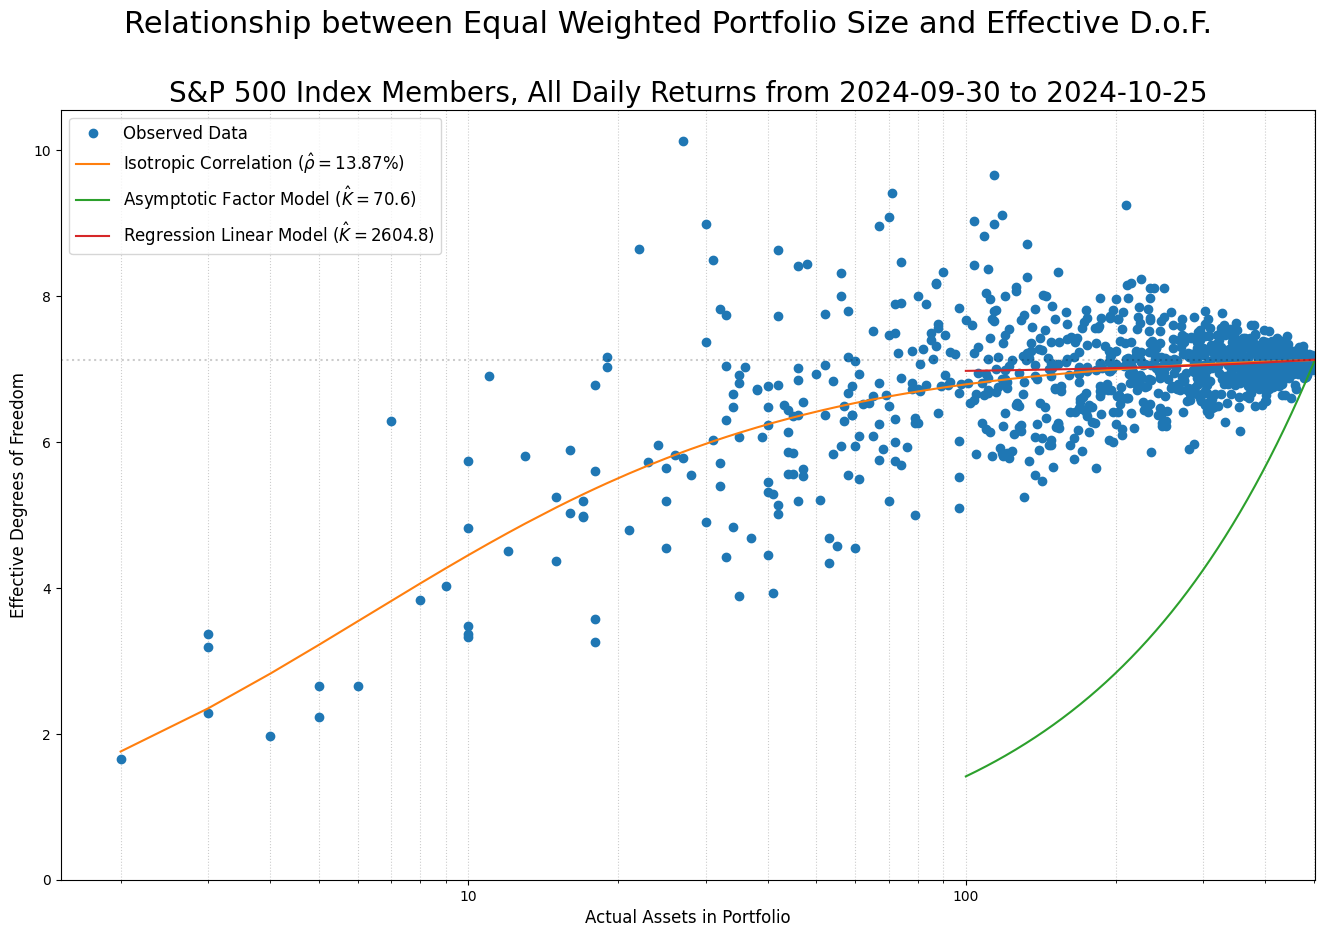

In [47]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=results["Assets"].to_numpy(),y:=results["Effective D.o.F."].to_numpy(),'o',label='Observed Data')
plot.plot(xp:=np.append([] if max(x)>100 else [zero],np.unique(np.sort(x))),xp/(one+(xp-one)*rho),'-',label='Isotropic Correlation ($\\hat{\\rho} = %.2f$%%)' % (rho*hundred))
plot.plot(xpp:=np.arange(Nmin,Nmax,one),xpp/Khat,'-',label="Asymptotic Factor Model ($\\hat{K} = %.1f$)" % Khat)
plot.plot(xpp,model.params[0]+model.params[1]*xpp,'-',label="Regression Linear Model ($\\hat{K} = %.1f$)" % Kreg)
plot.set_xscale('log' if max(x)>100 else 'linear')
plot.set_ylim(zero,None)
plot.set_xlabel("Actual Assets in Portfolio",fontsize=12)
plot.set_ylabel("Effective Degrees of Freedom",fontsize=12)
figure.suptitle(title:="Relationship between Equal Weighted Portfolio Size and Effective D.o.F.",fontsize=22)
plot.set_title("%s Index Members, %s Daily Returns from %s to %s" % (indexname,filter if filter is not None else "All",first_date,pd.Timestamp.today().strftime("%Y-%m-%d")),fontsize=20)
plot.set_xlim(zero,index.shape[0])
plot.legend(fontsize=12)
plot.axhline(Nstar,color='black',linestyle=':',alpha=0.2)
plot.xaxis.set_major_formatter(CountLabels())
plot.grid(which='both',axis='x',linestyle=':',color='black',alpha=0.2)
figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### Meta-Analysis
---

In [55]:
meta.index=pd.MultiIndex.from_tuples(meta.index)
meta.index.names=("Name","Filter")
meta=meta.loc[~meta.index.duplicated(keep='last')]
display(meta.sort_values("N",ascending=True))

try:
    meta.to_pickle("/content/drive/MyDrive/meta.pickle")
    nprint("Saved meta-analysis results to Google Drive.")

except:
    raise RuntimeError("You need to mount your Google Drive to save results.")

,,N,N*,rho,Khat,Kreg
Name,Filter,,,,,
S&P 500,,503.0,7.120521,0.138727,70.6409,2604.80523


16:24:24 Saved meta-analysis results to Google Drive.


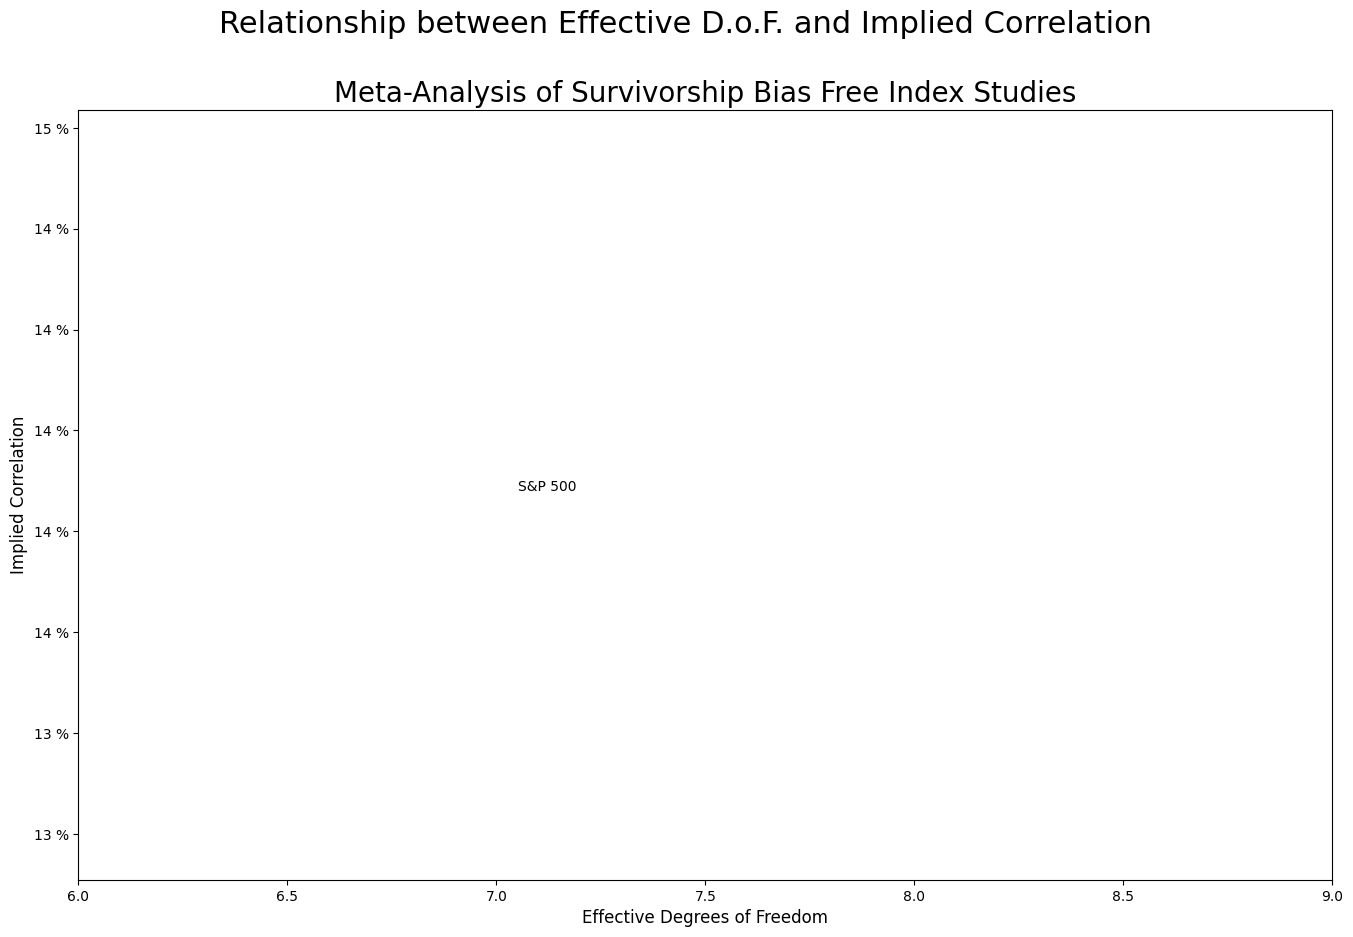

In [51]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.plot(x:=meta["N*"].to_numpy(),y:=meta["rho"].to_numpy()*hundred,'o',label='Observed Data',alpha=zero)
plot.set_xlabel("Effective Degrees of Freedom",fontsize=12)
plot.set_ylabel("Implied Correlation",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Relationship between Effective D.o.F. and Implied Correlation",fontsize=22)
plot.set_title("Meta-Analysis of Survivorship Bias Free Index Studies",fontsize=20)
plot.set_xlim(np.floor(meta["N*"]).min()-one,np.ceil(meta["N*"]).max()+one)

for i in meta.index:
    plot.text(x:=meta.loc[i,"N*"],y:=meta.loc[i,"rho"]*hundred,s:="\n".join(i),ha='center',va='center',fontsize=10)

figure.savefig(title+".png",dpi=300,bbox_inches='tight')

### $\LaTeX$ Code for the Formulae in the Medium Articles
---

$$
V_P=\mathbb{V}\!\left[\frac{1}{N}\sum_{i=1}^Nr_{it}\right]=\frac{1}{N^2}\mathbb{V}\!\left[\sum_{i=1}^Nr_{it}\right]
$$

$$
V_P=\frac{1}{N^2}\sum_{i=1}^N\sigma_i^2+\frac{2}{N^2}\sum_{i=1}^N\sum_{j=i+1}^N\sigma_i\sigma_j\rho_{ij}=V_I+V_C
$$

$$
V_I=\frac{1}{N}\left(\frac{1}{N}\sum_{i=1}^N\sigma_i^2\right)=\frac{\overline{\sigma^2}}{N}
$$

$$
\mathbb{V}[\bar{x}]=\frac{\sigma^2}{N}\;\mathrm{where}\;\mathbb{V}[x_i]=\mathbb{V}[x_j]=\sigma^2\;\mathrm{and}\;\mathbb{C}[x_i,x_j]=0\;\forall\;i,j
$$

$$
V_P=V_I\left(1+\frac{V_C}{V_I}\right)=\frac{\overline{\sigma^2}}{N}\left(1+\frac{V_C}{V_I}\right)
$$

$$
V_P=\frac{\overline{\sigma^2}}{N^*}\;\mathrm{where}\;N^*=N\frac{V_I}{V_P}
$$

$$
\sum_{N=1}^M\begin{pmatrix}M\\ N\end{pmatrix}=2^M-1
$$

$$
2^{503}-1\approx3.3\times10^{150}
$$

$$
\mathbb{V}[r_{it},r_{jt}]=\sigma_{it}\sigma_{jt}\rho\;\Leftrightarrow\;V_t=S_tRS_t\;\mathrm{where}\;R=\begin{pmatrix}
1&\rho&\cdots&\rho\\
\rho&1&\cdots&\rho\\
\vdots&&\ddots&\vdots\\
\rho&\rho&\cdots&1
\end{pmatrix}\;\mathrm{and}\;
S_t=\begin{pmatrix}
\sigma_{1t}&0&\cdots&0\\
0&\sigma_{2t}&\cdots&0\\
\vdots&&\ddots&\vdots\\
0&0&\cdots&\sigma_{Nt}
\end{pmatrix}
$$